# BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json
import requests

## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [2]:
#cptac.download(dataset='renalccrcc')

In [3]:
re = cptac.RenalCcrcc()
proteomics = re.get_proteomics()
clinical = re.get_clinical()

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [4]:
#Data cleaning. We want to get rid of non_clear cell carcinoma, 
#as it throws off our analysis, and isn't what we are studying
non_clear_cell_filter = clinical['histologic_type'] == 'non-Clear Cell renal cell carcinoma'
clinical = clinical[~non_clear_cell_filter]

In [5]:
#We also need to get rid of those samples in the datasets we plan to use. In this case, Proteomics.
rows_to_drop = ['S011', 'S097', 'S104', 'S107', 'S115', 'S119', 'S123']

#for i, item in enumerate(proteomics.index):
#    if item not in list(clinical.index):
#        rows_to_drop.append(item)
proteomics.drop(rows_to_drop)

print("Rows Dropped:")
print(rows_to_drop)

Rows Dropped:
['S011', 'S097', 'S104', 'S107', 'S115', 'S119', 'S123']


In [6]:
#Create a copy of the original Clinical DataFrame
annotations = pd.DataFrame(clinical.copy())

In [7]:
#Convert columns that should be numeric to numeric
annotations['age'] = annotations['age'].replace('>=90', 90)
annotations['age'] = pd.to_numeric(annotations['age'])

annotations['age_started_smoking'] = annotations['age_started_smoking'].replace('Unknown', np.nan)
annotations['age_started_smoking'] = pd.to_numeric(annotations['age_started_smoking'])

annotations['age_stopped_smoking'] = annotations['age_stopped_smoking'].replace('Unknown', np.nan)
annotations['age_stopped_smoking'] = pd.to_numeric(annotations['age_stopped_smoking'])

annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'] = annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'].replace('Unknown', np.nan)
annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'] = pd.to_numeric(annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'])

In [8]:
#Drop irrelevant columns
irrelevant_cols = ['Patient_ID', 'height_in_cm', 'weight_in_kg', 'race', 'ethnicity', 
                   'ethnicity_self_identified','tumor_site_other', 'sarcomatoid_features', 
                   'pathologic_findings_in_nonneoplastic_kidney_specify', 
                   'other_immunohistochemistry_specify', 'other_testing_performed', 
                   'other_coagulopathies', 'exposure_to_secondhand_smoke', 
                   'tumor_tissue_collection_clamps_used','tumor_tissue_collection_frozen_with_OCT', 
                   'preoperative_IV_sedation_administered',  'preoperative_IV_opiates_administered', 
                   'preoperative_IV_antiemetics_administered','preoperative_IV_anti_acids_administered', 
                   'other_preoperative_IV_medications_administered', 'platelets',
                   'local_anesthesia_agents_administered', 'regional_anesthesia_agents_administered', 
                   'IV_anesthesia_agents_administered', 'IV_narcotic_opiate_agents_administered', 
                   'IV_muscle_relaxants_administered', 'inhalation_anesthesia_agents_administered', 
                   'additional_anesthesia', 'other_medications_administered_during_surgery', 
                   'surgical_procedure', 'epochs_of_oxygen_desaturation', 'time_specimen_left_OR', 
                   'first_participant_temperature_recorded_in_OR', 'first_temperature_recorded_in_OR_units', 
                   'first_temperature_recorded_in_OR_celsius', 'time_of_first_temperature', 
                   'first_temperature_recorded_in_OR_fahrenheit', 'second_participant_temperature_recorded_in_OR', 
                   'second_temperature_recorded_in_OR_units','second_temperature_recorded_in_OR_celsius', 
                   'second_temperature_recorded_in_OR_fahrenheit', 'time_of_second_temperature', 
                   'Karnofsky_score_at_12months_follow_up', 'Karnofsky_score_at_24months_follow_up', 
                   'performance_status_scale_timing_at_12months_follow_up', 
                   'performance_status_scale_timing_at_24months_follow_up', 
                   'adjuvant_postoperative_radiation_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_radiation_therapy_at_24months_follow_up',  
                   'adjuvant_postoperative_immunological_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_immunological_therapy_at_24months_follow_up', 
                   'adjuvant_postoperative_pharmaceutical_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_pharmaceutical_therapy_at_24months_follow_up', 
                   'ECOG_score_at_12months_follow_up', 'ECOG_score_at_24months_follow_up', 
                   'specimen_id', 'slide_id', 'Presence_sarcomatoid_features', 
                   'non_cellular_component_description', 'meets_required_criteria', 
                   'histologic_type_of_normal_tissue', 'findings_not_consistent_with_local_pathology_report', 
                   'minutes_clamp_1_to_collection', 'minutes_clamp_2_to_collection', 
                   'consistent_with_diagnostic_report', 'patient_medications']

annotations = annotations.drop(irrelevant_cols, axis=1)

#Columns we should either drop, or be generally skeptical of in our analysis
questionable_cols = ['specify_distant_metastasis_documented_sites', 
                     'erythrocyte_sedimentation_rate', 
                     'renal_vein_or_vena_cava_thrombosis', 
                     'CO2_level_recorded_at_time_closest_to_organ_excision']

annotations = annotations.drop(questionable_cols, axis=1)

In [9]:
#Determine which columns are binary and which aren't
binary_cols = []
non_binary_cols = []

for col in annotations.columns:
    #this is the number of datapoints in a column
    if annotations[col].describe()[0] <= 10:
        annotations = annotations.drop(col, axis=1)
    elif len(annotations[col].value_counts()) == 2:
        binary_cols.append(col)
    elif len(annotations[col].value_counts()) > 2:
        if np.issubdtype(annotations[col].dtype, np.number):
            mean = annotations[col].mean()
            annotations[col]= bf.binarizeCutOff(annotations, col, mean, 
                                                "Above_Mean("+str(round(mean, 2))+")", 
                                                "Below_Mean("+str(round(mean, 2))+")")
        else:
            non_binary_cols.append(col)
    else:
        annotations = annotations.drop(col, axis=1)

## Step 2a: Binarize column values

In [10]:
tumor_site_map = {'Other':'Other',
                  'Upper pole':'Pole',
                  'Middle':'Pole',
                  'Lower pole':'Pole'}

annotations['tumor_site'] = bf.binarizeCategorical(annotations,
                                                   'tumor_site',
                                                   tumor_site_map)

In [11]:
histologic_grade_map = {'G1':'G1or2',
                        'G2':'G1or2',
                        'G3':'G3or4',
                        'G4':'G3or4'}

annotations['histologic_grade'] = bf.binarizeCategorical(annotations, 
                                                         'histologic_grade',
                                                         histologic_grade_map)

In [12]:
tumor_stage_pathological_map = {'Stage I':'StageIorII', 
                                'Stage II':'StageIorII', 
                                'Stage III':'StageIIIorIV',
                                'Stage V':'StageIIIorV'}

annotations['tumor_stage_pathological'] = bf.binarizeCategorical(annotations,
                                                                 'tumor_stage_pathological',
                                                                 tumor_stage_pathological_map)

In [13]:
pathologic_staging_map = {'pT3a':'pT3or4', 
                          'pT1a':'pT1or2', 
                          'pT1b':'pT1or2', 
                          'pT2a':'pT1or2', 
                          'pT2b':'pT1or2', 
                          'pT3':'pT3or4', 
                          'pT3b':'pT3or4', 
                          'pT4':'pT3or4'}

annotations['pathologic_staging_primary_tumor_pT'] = bf.binarizeCategorical(annotations,
                                                                            'pathologic_staging_primary_tumor_pT',
                                                                            pathologic_staging_map)

In [14]:
pathologic_lymph_map = {'pNX':'pNX', 
                        'pN0':'pN0or1', 
                        'pN1':'pN0or1'}

annotations['pathologic_staging_regional_lymph_nodes_pN'] = bf.binarizeCategorical(annotations,
                                                                                   'pathologic_staging_regional_lymph_nodes_pN',
                                                                                   pathologic_lymph_map)

In [15]:
pathologic_metastasis_map = {'Staging Incomplete':np.nan,
                             'No pathologic evidence of distant metastasis':'No',
                             'pM1':'pM1'}

annotations['pathologic_staging_distant_metastasis_pM'] = bf.binarizeCategorical(annotations,
                                                                                 'pathologic_staging_distant_metastasis_pM',
                                                                                 pathologic_metastasis_map)

In [16]:
annotations['clinical_staging_distant_metastasis_cM'] = annotations['clinical_staging_distant_metastasis_cM'].replace('Staging Incomplete', np.nan)

In [17]:
serum_calcium_map = {'Not evaluated':np.nan,
                     'Unknown':np.nan,
                     'Normal':'Normal',
                     'Low':'Abnormal',
                     'Elevated':'Abnormal'}

annotations['serum_calcium'] = bf.binarizeCategorical(annotations,
                                                      'serum_calcium',
                                                      serum_calcium_map)

In [18]:
hemoglobin_map = {'Not evaluated':np.nan,
                  'Unknown':np.nan,
                  'Normal':'Normal',
                  'Low':'Abnormal',
                  'Elevated':'Abnormal'}

annotations['hemoglobin'] = bf.binarizeCategorical(annotations,
                                                   'hemoglobin',
                                                   hemoglobin_map)

In [19]:
white_cell_map = {'Not evaluated':np.nan,
                  'Unknown':np.nan,
                  'Normal':'Normal',
                  'Low':'Abnormal',
                  'Elevated':'Abnormal'}

annotations['white_cell_count'] = bf.binarizeCategorical(annotations,
                                                         'white_cell_count',
                                                         white_cell_map)

In [20]:
country_map = {'United States':'US', 
               'Poland':'Other',
               'Other':'Other', 
               'Ukraine':'Other',
               'Vietnam':'Other'}

annotations['participant_country_of_origin'] = bf.binarizeCategorical(annotations,
                                                                      'participant_country_of_origin',
                                                                      country_map)

In [21]:
annotations['margin_status'] = annotations['margin_status'].replace('Cannot be assessed', np.nan)

In [22]:
annotations['residual_tumor'] = annotations['residual_tumor'].replace('RX:Presence of residual tumor cannot be assessed', np.nan)

In [23]:
annotations['other_immunohistochemistry_performed'] = annotations['other_immunohistochemistry_performed'].replace('Unknown', np.nan)

In [24]:
alcohol_map = {'Lifelong non-drinker':'Non-drinker',
               'Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women':'Previous_or_Current_Drinker',
               'Alcohol consumption history not available':np.nan,
               'Alcohol consumption more than 2 drinks per day for men and more than 1 drink per day for women':'Previous_or_Current_Drinker',
               'Consumed alcohol in the past, but currently a non-drinker':'Previous_or_Current_Drinker'}

annotations['alcohol_consumption'] = bf.binarizeCategorical(annotations, 
                                                            'alcohol_consumption', 
                                                            alcohol_map)

In [25]:
tobacco_map = {'Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime':'Non-smoker', 
               'Smoking history not available':np.nan, 
               'Current reformed smoker within past 15 years':'Non-smoker', 
               'Current smoker: Includes daily and non-daily smokers':'Current Smoker', 
               'Current reformed smoker, more than 15 years':'Non-smoker'}

annotations['tobacco_smoking_history'] = bf.binarizeCategorical(annotations, 
                                                                'tobacco_smoking_history', 
                                                                tobacco_map)

In [26]:
annotations['tumor_status_at_12months_follow_up'] = annotations['tumor_status_at_12months_follow_up'].replace('Unknown', np.nan)

In [27]:
annotations['tumor_status_at_24months_follow_up'] = annotations['tumor_status_at_24months_follow_up'].replace('Unknown', np.nan)

In [28]:
success_map1 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease_or_Deceased', 
                'Patient Deceased':'Persistent_Disease_or_Deceased'}

annotations['success_of_initial_treatment_at_12months_follow_up'] = bf.binarizeCategorical(annotations, 
                                                                                           'success_of_initial_treatment_at_12months_follow_up', 
                                                                                           success_map1)

In [29]:
success_map2 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease'}

annotations['success_of_initial_treatment_at_24months_follow_up'] = bf.binarizeCategorical(annotations, 
                                                                                           'success_of_initial_treatment_at_24months_follow_up', 
                                                                                           success_map1)

In [30]:
success_map3 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease_or_Deceased', 
                'Patient Deceased':'Persistent_Disease_or_Deceased'}

annotations['success_of_treatment_at_12months_follow_up'] = bf.binarizeCategorical(annotations,
                                                                                   'success_of_treatment_at_12months_follow_up',
                                                                                   success_map3)

In [31]:
success_map4 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease'}

annotations['success_of_treatment_at_24months_follow_up'] = bf.binarizeCategorical(annotations,
                                                                                   'success_of_treatment_at_24months_follow_up',
                                                                                   success_map4)

In [32]:
annotations['new_tumor_event_after_initial_treatment_at_12months_follow_up'] = annotations['new_tumor_event_after_initial_treatment_at_12months_follow_up'].replace('Unknown', np.nan)

In [33]:
annotations['new_tumor_event_after_initial_treatment_at_24months_follow_up'] = annotations['new_tumor_event_after_initial_treatment_at_24months_follow_up'].replace('Unknown', np.nan)

## Step 3: Perform outliers analysis

First, we create our outlier tables for both up and down regulated gene outliers.

In [34]:
outliers_up = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                       up_or_down='up', 
                                       aggregate=False, 
                                       frac_table=False)

In [35]:
outliers_down = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='down', 
                                         aggregate=False, 
                                         frac_table=False)

Next, we take these tables, and split them in half.  This is because the second half of the table is the inverse of the first (1st: _outliers; 2nd: _notOutliers).  We will then create a dictionary {key = SampleID : value = list of outliers} that we will use later to find personalized medicines for specific samples.

In [36]:
length = int(len(outliers_up.index) / 2)
only_outliers_up = outliers_up[:length]
outlier_up_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_up.iloc[i] == 1.0
    value = list(only_outliers_up.iloc[i][my_filter].index)
    outlier_up_dict[key] = value

In [37]:
length = int(len(outliers_down.index) / 2)
only_outliers_down = outliers_down[:length]
outlier_down_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_down.iloc[i] == 1.0
    value = list(only_outliers_down.iloc[i][my_filter].index)
    outlier_down_dict[key] = value

## Step 4: Wrap your A/B test into the outliers analysis, and create a table
Note: compare_groups_outliers will break if there are duplicate gene names. Be sure to use the 
renameDuplicateColumns function if there are indexing errors

In [38]:
bf.renameDuplicateColumns(outliers_up)
bf.renameDuplicateColumns(outliers_down)

In [39]:
results_up = blsh.compare_groups_outliers(outliers_up, 
                                          annotations)

In [40]:
results_down = blsh.compare_groups_outliers(outliers_down, 
                                            annotations)

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [41]:
results_up = results_up.dropna(axis=0, how='all')
results_down = results_down.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

First, we will determine which clinical attributes have significant enrichments, and save them to a list for both up-regulated outliers, and down-regulated outliers.

In [42]:
#Drop Columns with less than 4 significant up-regulated enrichments
#print("TESTING FOR UP-REGULATION:")
sig_cols_up = []
for col in results_up.columns:
    sig_col = bf.significantEnrichments(results_up, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_up.append(sig_col)
        #print(sig_col.head())
    else:
        results_up = results_up.drop(col, axis=1)

In [43]:
#Drop Columns with less than 4 significant down-regulated enrichments
sig_cols_down = []
for col in results_down.columns:
    sig_col = bf.significantEnrichments(results_down, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_down.append(sig_col)
    else:
        results_down = results_down.drop(col, axis=1)

In [44]:
#Here we will link clinical attributes with significantly up-regulated genes
sig_genes_up = {}
for i, col in enumerate(sig_cols_up):
    list_of_genes = list(col.index)
    sig_genes_up[sig_cols_up[i].columns[0][:-9]] = list_of_genes   

#And then down-regulated genes
sig_genes_down = {}
for i, col in enumerate(sig_cols_down):
    list_of_genes = list(col.index)
    sig_genes_down[sig_cols_down[i].columns[0][:-9]] = list_of_genes

Then we will plot the results, to visualize what genes are significantly enriched for the clinical attributes.

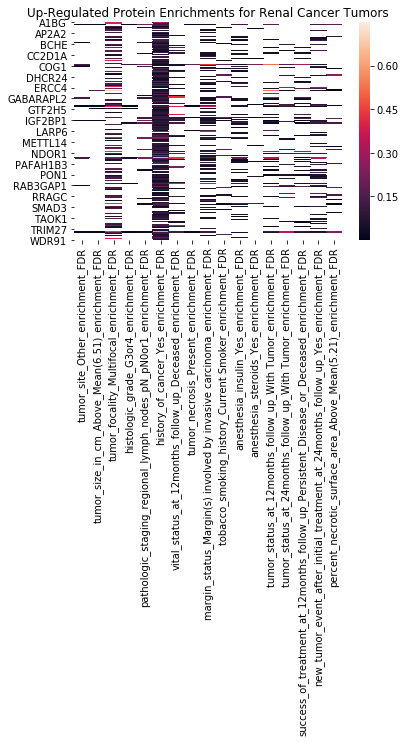

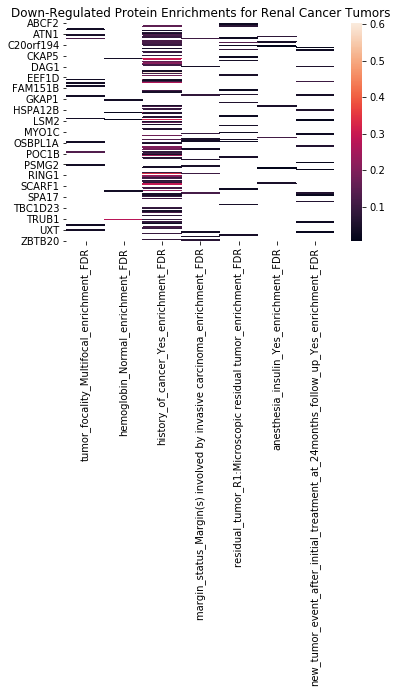

In [45]:
ax1 = plt.axes()
sns.heatmap(results_up, ax = ax1)
ax1.set_title('Up-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

ax2 = plt.axes()
sns.heatmap(results_down, ax = ax2)
ax2.set_title('Down-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

## Step 6: Perform Gene-set Enrichment Analysis and link with cancer drug database.

In [46]:
for col in sig_cols_up:
    col_name = col.columns[0]
    col_name = "_".join((col_name.split(" ")))
    print(col_name)
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/renal')
    #print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

tumor_site_Other_P_values


2019-08-19 16:48:07,689 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                       Term Overlap   P-value  \
0  KEGG_2019_Human  Selenocompound metabolism    1/17  0.006781   
1  KEGG_2019_Human   Hepatocellular carcinoma   1/168  0.065268   
2  KEGG_2019_Human         Pathways in cancer   1/530  0.193376   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0  147.058824   
1               1.0            0                     0   14.880952   
2               1.0            0                     0    4.716981   

   Combined Score   Genes  
0      734.359493  TXNRD1  
1       40.613893  TXNRD1  
2        7.750568  TXNRD1  
tumor_size_in_cm_Above_Mean(6.51)_P_values


2019-08-19 16:48:10,595 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                       Term Overlap   P-value  \
0  KEGG_2019_Human  Selenocompound metabolism    1/17  0.004243   
1  KEGG_2019_Human   Hepatocellular carcinoma   1/168  0.041304   
2  KEGG_2019_Human         Pathways in cancer   1/530  0.125673   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0  235.294118   
1               1.0            0                     0   23.809524   
2               1.0            0                     0    7.547170   

   Combined Score   Genes  
0     1285.282536  TXNRD1  
1       75.876009  TXNRD1  
2       15.653391  TXNRD1  
tumor_focality_Multifocal_P_values


2019-08-19 16:48:13,518 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                     Term Overlap  \
0   KEGG_2019_Human            Starch and sucrose metabolism    1/36   
1   KEGG_2019_Human                              Ferroptosis    1/40   
2   KEGG_2019_Human                    Pyrimidine metabolism    1/57   
3   KEGG_2019_Human                                Mitophagy    1/65   
4   KEGG_2019_Human                              Shigellosis    1/65   
5   KEGG_2019_Human    RIG-I-like receptor signaling pathway    1/70   
6   KEGG_2019_Human                mRNA surveillance pathway    1/91   
7   KEGG_2019_Human             Longevity regulating pathway   1/102   
8   KEGG_2019_Human                      Platelet activation   1/124   
9   KEGG_2019_Human                                Autophagy   1/128   
10  KEGG_2019_Human                 Apelin signaling pathway   1/137   
11  KEGG_2019_Human                              Necroptosis   1/162   
12  KEGG_2019_Human                            RNA transport   1

2019-08-19 16:48:16,458 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                       Term Overlap  \
0   KEGG_2019_Human                  Selenocompound metabolism    1/17   
1   KEGG_2019_Human                  Type II diabetes mellitus    1/46   
2   KEGG_2019_Human            Arginine and proline metabolism    1/49   
3   KEGG_2019_Human      Regulation of lipolysis in adipocytes    1/55   
4   KEGG_2019_Human            Adipocytokine signaling pathway    1/69   
5   KEGG_2019_Human               Longevity regulating pathway   1/102   
6   KEGG_2019_Human                         Insulin resistance   1/108   
7   KEGG_2019_Human                     AMPK signaling pathway   1/120   
8   KEGG_2019_Human                                  Autophagy   1/128   
9   KEGG_2019_Human                     FoxO signaling pathway   1/132   
10  KEGG_2019_Human                  Insulin signaling pathway   1/137   
11  KEGG_2019_Human  Non-alcoholic fatty liver disease (NAFLD)   1/149   
12  KEGG_2019_Human                 cG

2019-08-19 16:48:19,460 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                 Term Overlap   P-value  \
0   KEGG_2019_Human            Selenocompound metabolism    1/17  0.006781   
1   KEGG_2019_Human      Staphylococcus aureus infection    1/68  0.026883   
2   KEGG_2019_Human                 Salmonella infection    1/86  0.033892   
3   KEGG_2019_Human                   Salivary secretion    1/90  0.035444   
4   KEGG_2019_Human             Hepatocellular carcinoma   1/168  0.065268   
5   KEGG_2019_Human  NOD-like receptor signaling pathway   1/178  0.069033   
6   KEGG_2019_Human                         Tuberculosis   1/179  0.069408   
7   KEGG_2019_Human                       Focal adhesion   1/199  0.076895   
8   KEGG_2019_Human              Proteoglycans in cancer   1/201  0.077641   
9   KEGG_2019_Human               MAPK signaling pathway   1/295  0.112103   
10  KEGG_2019_Human                   Pathways in cancer   1/530  0.193376   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds R

[85 rows x 10 columns]
vital_status_at_12months_follow_up_Deceased_P_values


2019-08-19 16:48:28,600 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Human    Aldosterone-regulated sodium reabsorption    1/37   
1   KEGG_2019_Human  Amino sugar and nucleotide sugar metabolism    1/48   
2   KEGG_2019_Human                       Cholesterol metabolism    1/50   
3   KEGG_2019_Human                        p53 signaling pathway    1/72   
4   KEGG_2019_Human                         Salmonella infection    1/86   
5   KEGG_2019_Human                                     Lysosome   1/123   
6   KEGG_2019_Human                                   Cell cycle   1/124   
7   KEGG_2019_Human                                  Necroptosis   1/162   
8   KEGG_2019_Human                                RNA transport   1/165   
9   KEGG_2019_Human          NOD-like receptor signaling pathway   1/178   
10  KEGG_2019_Human                               Focal adhesion   1/199   
11  KEGG_2019_Human                      Proteoglycans in cancer   1/201   
12  KEGG_201

2019-08-19 16:48:31,494 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Human                    Selenocompound metabolism    1/17   
1   KEGG_2019_Human                           Pathways in cancer   2/530   
2   KEGG_2019_Human          Antigen processing and presentation    1/77   
3   KEGG_2019_Human                      IL-17 signaling pathway    1/93   
4   KEGG_2019_Human                              Prostate cancer    1/97   
5   KEGG_2019_Human      Progesterone-mediated oocyte maturation    1/99   
6   KEGG_2019_Human                    Th17 cell differentiation   1/107   
7   KEGG_2019_Human                   Estrogen signaling pathway   1/137   
8   KEGG_2019_Human       Fluid shear stress and atherosclerosis   1/139   
9   KEGG_2019_Human                                  Necroptosis   1/162   
10  KEGG_2019_Human  Protein processing in endoplasmic reticulum   1/165   
11  KEGG_2019_Human                     Hepatocellular carcinoma   1/168   
12  KEGG_201

[82 rows x 10 columns]
tobacco_smoking_history_Current_Smoker_P_values


2019-08-19 16:48:39,226 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                      Term Overlap   P-value  \
0  KEGG_2019_Human  Homologous recombination    1/41  0.014264   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0   69.686411   

   Combined Score  Genes  
0      296.168151  BARD1  
anesthesia_insulin_Yes_P_values


2019-08-19 16:48:42,494 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                               Term  \
0   KEGG_2019_Human        Protein processing in endoplasmic reticulum   
1   KEGG_2019_Human                       Epstein-Barr virus infection   
2   KEGG_2019_Human                                        Shigellosis   
3   KEGG_2019_Human                                          Autophagy   
4   KEGG_2019_Human                    Terpenoid backbone biosynthesis   
5   KEGG_2019_Human                           Renin-angiotensin system   
6   KEGG_2019_Human                          Calcium signaling pathway   
7   KEGG_2019_Human                   Mucin type O-glycan biosynthesis   
8   KEGG_2019_Human                                        Ferroptosis   
9   KEGG_2019_Human                                         Proteasome   
10  KEGG_2019_Human                          Type II diabetes mellitus   
11  KEGG_2019_Human                         Hedgehog signaling pathway   
12  KEGG_2019_Human                   

[81 rows x 10 columns]
anesthesia_steroids_Yes_P_values


2019-08-19 16:48:45,398 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                             Term Overlap  \
0   KEGG_2019_Human           Nicotinate and nicotinamide metabolism    1/30   
1   KEGG_2019_Human                  Fructose and mannose metabolism    1/33   
2   KEGG_2019_Human      Amino sugar and nucleotide sugar metabolism    1/48   
3   KEGG_2019_Human                            p53 signaling pathway    1/72   
4   KEGG_2019_Human                                GABAergic synapse    1/89   
5   KEGG_2019_Human                               Salivary secretion    1/90   
6   KEGG_2019_Human                               Morphine addiction    1/91   
7   KEGG_2019_Human                       Hematopoietic cell lineage    1/97   
8   KEGG_2019_Human                            Circadian entrainment    1/97   
9   KEGG_2019_Human                             Pancreatic secretion    1/98   
10  KEGG_2019_Human                              Cholinergic synapse   1/112   
11  KEGG_2019_Human                     

2019-08-19 16:48:49,760 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Human  Protein processing in endoplasmic reticulum   3/165   
1   KEGG_2019_Human             Mucin type O-glycan biosynthesis    1/31   
2   KEGG_2019_Human                    Type II diabetes mellitus    1/46   
3   KEGG_2019_Human              Arginine and proline metabolism    1/49   
4   KEGG_2019_Human        Regulation of lipolysis in adipocytes    1/55   
5   KEGG_2019_Human                  Aminoacyl-tRNA biosynthesis    1/66   
6   KEGG_2019_Human              Adipocytokine signaling pathway    1/69   
7   KEGG_2019_Human          Antigen processing and presentation    1/77   
8   KEGG_2019_Human            Ribosome biogenesis in eukaryotes   1/101   
9   KEGG_2019_Human                 Longevity regulating pathway   1/102   
10  KEGG_2019_Human    Chagas disease (American trypanosomiasis)   1/103   
11  KEGG_2019_Human                           Insulin resistance   1/108   
12  KEGG_201

2019-08-19 16:48:52,649 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []
success_of_treatment_at_12months_follow_up_Persistent_Disease_or_Deceased_P_values


2019-08-19 16:48:55,527 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Human          Antigen processing and presentation    2/77   
1   KEGG_2019_Human  Protein processing in endoplasmic reticulum   2/165   
2   KEGG_2019_Human                 Epstein-Barr virus infection   2/201   
3   KEGG_2019_Human             Mucin type O-glycan biosynthesis    1/31   
4   KEGG_2019_Human                          MicroRNAs in cancer   2/299   
5   KEGG_2019_Human                    Type II diabetes mellitus    1/46   
6   KEGG_2019_Human              Arginine and proline metabolism    1/49   
7   KEGG_2019_Human                       Cholesterol metabolism    1/50   
8   KEGG_2019_Human        Regulation of lipolysis in adipocytes    1/55   
9   KEGG_2019_Human                                  Shigellosis    1/65   
10  KEGG_2019_Human              Adipocytokine signaling pathway    1/69   
11  KEGG_2019_Human                     ECM-receptor interaction    1/82   
12  KEGG_201

42        1.656035       HSP90AB1  
new_tumor_event_after_initial_treatment_at_24months_follow_up_Yes_P_values


2019-08-19 16:48:58,428 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                                     Term Overlap   P-value  \
0  KEGG_2019_Human                Selenocompound metabolism    1/17  0.009313   
1  KEGG_2019_Human                 Renin-angiotensin system    1/23  0.012581   
2  KEGG_2019_Human                 Hepatocellular carcinoma   1/168  0.088636   
3  KEGG_2019_Human                Calcium signaling pathway   1/188  0.098698   
4  KEGG_2019_Human  Neuroactive ligand-receptor interaction   1/338  0.171000   
5  KEGG_2019_Human                       Pathways in cancer   1/530  0.255845   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0  106.951872   
1               1.0            0                     0   79.051383   
2               1.0            0                     0   10.822511   
3               1.0            0                     0    9.671180   
4               1.0            0                     0    5.379236   
5           

2019-08-19 16:49:01,360 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                                 Term Overlap   P-value  \
0  KEGG_2019_Human                       Protein export    1/23  0.008023   
1  KEGG_2019_Human  Complement and coagulation cascades    1/79  0.027328   
2  KEGG_2019_Human                             Lysosome   1/123  0.042270   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0  124.223602   
1               1.0            0                     0   36.166365   
2               1.0            0                     0   23.228804   

   Combined Score  Genes  
0      599.427861  SRP72  
1      130.192765     F5  
2       73.488545  GNPTG  


In [47]:
for col in sig_cols_down:
    col_name = col.columns[0]
    col_name = "_".join((col_name.split(" ")))
    print(col_name)
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/renal')
    #print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

tumor_focality_Multifocal_P_values


2019-08-19 16:49:04,253 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


hemoglobin_Normal_P_values


2019-08-19 16:49:16,118 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


history_of_cancer_Yes_P_values


2019-08-19 16:49:19,047 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


margin_status_Margin(s)_involved_by_invasive_carcinoma_P_values


2019-08-19 16:49:21,911 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


residual_tumor_R1:Microscopic_residual_tumor_P_values


2019-08-19 16:49:24,732 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


anesthesia_insulin_Yes_P_values


2019-08-19 16:49:27,655 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


new_tumor_event_after_initial_treatment_at_24months_follow_up_Yes_P_values


2019-08-19 16:49:30,491 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


In [48]:
#All requests for up-regulation
dgidb_requests_up = list(map(bf.dgidb_get_request, sig_genes_up.values()))

In [49]:
#S125 example
s125_example = bf.dgidb_get_request(outlier_up_dict['S125'], genes = True, 
                                    interaction_types = ['inhibitor'])
s125_dict = bf.dgidb_json_parse(s125_example, genes = True)
print(json.dumps(s125_dict, indent=4))

{
    "APEX1": {
        "LUCANTHONE": [
            "inhibitor"
        ]
    },
    "ATP1B2": {
        "ACETYLDIGITOXIN": [
            "inhibitor"
        ],
        "DIGOXIN": [
            "inhibitor"
        ],
        "DIGITOXIN": [
            "inhibitor"
        ],
        "DESLANOSIDE": [
            "inhibitor"
        ]
    },
    "CDK6": {
        "(7S)-HYDROXYL-STAUROSPORINE": [
            "inhibitor"
        ],
        "PHA-793887": [
            "inhibitor"
        ],
        "ALVOCIDIB": [
            "inhibitor"
        ],
        "Roniciclib": [
            "inhibitor"
        ],
        "APREMILAST": [
            "inhibitor"
        ],
        "RIBOCICLIB SUCCINATE": [
            "inhibitor"
        ],
        "G1T28-1": [
            "inhibitor"
        ],
        "AZD-5438": [
            "inhibitor"
        ],
        "Ribociclib": [
            "inhibitor",
            "antagonist"
        ],
        "PALBOCICLIB": [
            "Inhibitor",
            "inh

In [50]:
dgidb_requests_down = []

for col in sig_cols_down:
    sig_genes = list(col.index)
    json_obj = bf.dgidb_get_request(sig_genes)
    dgidb_requests_down.append(json_obj)

In [51]:
#All requests for down-regulation
dgidb_requests_down = list(map(bf.dgidb_get_request, sig_genes_down.values()))

In [52]:
print('UP-REGULATED:\n')
for i, request in enumerate(dgidb_requests_up):
    print('Genes and drugs for: ', sig_cols_up[i].columns[0])
    drug_dict_up = bf.dgidb_json_parse(request, genes=True)
    print(json.dumps(drug_dict_up, indent=4), '\n')

UP-REGULATED:

Genes and drugs for:  tumor_site_Other_P_values
{
    "TXNRD1": {
        "ARSENIC TRIOXIDE": [
            "inhibitor"
        ],
        "MOTEXAFIN GADOLINIUM": [],
        "CHEMBL449269": [],
        "FLAVIN ADENINE DINUCLEOTIDE": [],
        "SPERMIDINE": [],
        "FOTEMUSTINE": []
    }
} 

Genes and drugs for:  tumor_size_in_cm_Above_Mean(6.51)_P_values
{
    "TXNRD1": {
        "ARSENIC TRIOXIDE": [
            "inhibitor"
        ],
        "MOTEXAFIN GADOLINIUM": [],
        "CHEMBL449269": [],
        "FLAVIN ADENINE DINUCLEOTIDE": [],
        "SPERMIDINE": [],
        "FOTEMUSTINE": []
    }
} 

Genes and drugs for:  tumor_focality_Multifocal_P_values
{
    "HDAC4": {
        "TASQUINIMOD": [
            "allosteric modulator"
        ],
        "BELINOSTAT": [
            "inhibitor"
        ],
        "CUDC-101": [
            "inhibitor"
        ],
        "DACINOSTAT": [
            "inhibitor"
        ],
        "CHEMBL1213492": [
            "inhibito

} 

Genes and drugs for:  vital_status_at_12months_follow_up_Deceased_P_values
{
    "TFPI2": {
        "HEPARIN": []
    }
} 

Genes and drugs for:  tumor_necrosis_Present_P_values
{
    "HSP90AB1": {
        "RETASPIMYCIN": [
            "inhibitor"
        ],
        "NVP-AUY922": [
            "inhibitor"
        ],
        "GANETESPIB": [
            "inhibitor"
        ],
        "TANESPIMYCIN": [
            "inhibitor"
        ],
        "RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)": [
            "inhibitor"
        ],
        "ONALESPIB": [],
        "CHEMBL399530": [],
        "ALVESPIMYCIN": [],
        "RADICICOL": [],
        "GELDANAMYCIN": [],
        "CHEMBL383189": [],
        "CHEMBL2204502": [],
        "CHEMBL553939": [],
        "CHEMBL113690": [],
        "CHEMBL2170470": []
    },
    "TXNRD1": {
        "ARSENIC TRIOXIDE": [
            "inhibitor"
        ],
        "MOTEXAFIN GADOLINIUM": [],
        "CHEMBL449269": [],
        "FLAVIN ADENINE DINUCLEOTIDE": []

} 

Genes and drugs for:  new_tumor_event_after_initial_treatment_at_24months_follow_up_Yes_P_values
{
    "LNPEP": {
        "TOSEDOSTAT": [
            "inhibitor"
        ]
    },
    "P2RX4": {
        "ESLICARBAZEPINE ACETATE": [
            "antagonist"
        ]
    },
    "TXNRD1": {
        "ARSENIC TRIOXIDE": [
            "inhibitor"
        ],
        "MOTEXAFIN GADOLINIUM": [],
        "CHEMBL449269": [],
        "FLAVIN ADENINE DINUCLEOTIDE": [],
        "SPERMIDINE": [],
        "FOTEMUSTINE": []
    }
} 

Genes and drugs for:  percent_necrotic_surface_area_Above_Mean(5.21)_P_values
{
    "CPN1": {
        "PYRAZINAMIDE": [
            "inhibitor"
        ]
    },
    "F5": {
        "DROTRECOGIN ALFA (ACTIVATED)": [
            "multitarget",
            "antagonist",
            "inhibitor"
        ],
        "TAMOXIFEN": [],
        "ESTRONE SODIUM SULFATE": [],
        "THROMBOMODULIN ALFA": [],
        "ELTROMBOPAG": [],
        "THROMBIN": []
    },
    "SHBG": {
 

In [53]:
print('DOWN-REGULATED:\n')
for i, request in enumerate(dgidb_requests_down):
    print('Genes and drugs for: ' + sig_cols_down[i].columns[0] +':\n')
    drug_dict_down = bf.dgidb_json_parse(request, genes=True)
    print(json.dumps(drug_dict_up, indent=4), '\n')

DOWN-REGULATED:

Genes and drugs for: tumor_focality_Multifocal_P_values:

{
    "CPN1": {
        "PYRAZINAMIDE": [
            "inhibitor"
        ]
    },
    "F5": {
        "DROTRECOGIN ALFA (ACTIVATED)": [
            "multitarget",
            "antagonist",
            "inhibitor"
        ],
        "TAMOXIFEN": [],
        "ESTRONE SODIUM SULFATE": [],
        "THROMBOMODULIN ALFA": [],
        "ELTROMBOPAG": [],
        "THROMBIN": []
    },
    "SHBG": {
        "SPIRONOLACTONE": [
            "binder"
        ],
        "BUSULFAN": [],
        "LISINOPRIL": [],
        "NORGESTREL": [],
        "DROLOXIFENE": []
    }
} 

Genes and drugs for: hemoglobin_Normal_P_values:

No Gene/Drug interactions
{
    "CPN1": {
        "PYRAZINAMIDE": [
            "inhibitor"
        ]
    },
    "F5": {
        "DROTRECOGIN ALFA (ACTIVATED)": [
            "multitarget",
            "antagonist",
            "inhibitor"
        ],
        "TAMOXIFEN": [],
        "ESTRONE SODIUM SULFATE":